# Retrain translation model

Let's (1) assess the bias problem with a pretrained NMT model (from [MBART](https://huggingface.co/facebook/mbart-large-50); backup [here](https://huggingface.co/Helsinki-NLP/opus-mt-mul-en?text=el+ingeniero+se+cas%C3%B3+con+su+novio)); (2) retrain with same-gender and diff-gender data; (3) re-assess bias.

## Pretrain model
Let's follow the procedure [here](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/translation.ipynb#scrollTo=545PP3o8IrJV) to retrain the MBART model using ES-EN, FR-EN, IT-EN data from the TED talk corpus.

In [ ]:
from datasets import load_dataset


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_name = 'facebook/mbart-large'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir='data/')
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='data/')

In [2]:
## load model
# test 
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt", cache_dir='data/model_cache/')
tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt", cache_dir='data/model_cache/')
# txt = "उसने अपने पति को चूमा"
# tokenizer.src_lang = "hi_IN"
# txt = "la femme s'est mariée avec son épouse"
# tokenizer.src_lang = "fr_XX"
## TODO: Spanish generates "committee" garbage
txt = "la mujer besó a su esposa"
tokenizer.src_lang = "es_XX"
# txt = "la donna baciò sua moglie"
# tokenizer.src_lang = "it_IT"
encoded_hi = tokenizer(txt, return_tensors="pt")
generated_tokens = model.generate(**encoded_hi, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
# model_inputs = tokenizer(src_text, return_tensors='pt')
# output = model.generate(**model_inputs, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
# print(tokenizer.batch_decode(output))

["The Committee recommends that the State party take all necessary measures to ensure that the right to adequate housing is guaranteed in the State party's next periodic report, and that the State party take all necessary measures to ensure that the right to adequate housing is guaranteed in its next periodic report."]

## Load pretrained model

In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_name = 'Helsinki-NLP/opus-mt-mul-en'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir='data/')
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='data/')

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
import torch
test_sent = 'el abogado besó a su novia'
test_input = tokenizer(test_sent, return_tensors='pt')
with torch.no_grad():
    test_output = model.generate(**test_input)
print(tokenizer.batch_decode(test_output))

['<pad> the lawyer beats his girlfriend.']


### Evaluate model on diff-gender, same-gender sentences
Now that we've trained separate MT models on "default" data (EuroParl) and generated sample sentences for the same/diff gender sentences, let's see what the output looks like.

In [53]:
## load data
import pandas as pd
relationship_sentence_data = pd.read_csv('data/MT/translation_data_type=relationship_sentences.gz',
                                         sep='\t', compression='gzip')
# fix spacing??
relationship_sentence_data = relationship_sentence_data.assign(**{'sent' : relationship_sentence_data.loc[:, 'sent'].apply(lambda x: x.strip())})
display(relationship_sentence_data.head())

,sent,lang,subject_word,relationship_word,subject_gender,relationship_topic,relationship_gender,relationship_type,subject_word_en,relationship_word_en,relationship_word_category,sent_en
0,el autor conoció a su novio en una cita.,es,autor,novio,male,date,male,same_gender,author,boyfriend,FRIEND,the author met his boyfriend on a date.
1,l'auteur a rencontré son petit ami à un rendez...,fr,auteur,petit ami,male,date,male,same_gender,author,boyfriend,FRIEND,the author met his boyfriend on a date.
2,l'autore ha incontrato il suo ragazzo ad un ap...,it,autore,ragazzo,male,date,male,same_gender,author,boyfriend,FRIEND,the author met his boyfriend on a date.
3,el autor conoció a su prometido en una cita.,es,autor,prometido,male,date,male,same_gender,author,fiance,ENGAGE,the author met his fiancé on a date.
4,l'auteur a rencontré son fiancé à un rendez-vous.,fr,auteur,fiancé,male,date,male,same_gender,author,fiance,ENGAGE,the author met his fiancé on a date.


In [57]:
## load generated data
langs = relationship_sentence_data.loc[:, 'lang'].unique()
generated_data = []
for lang_i in langs:
    generated_data_file_i = f'data/MT/translation_data_type=relationship_lang={lang_i}/test_data_output.gz'
    generated_data_i = pd.read_csv(generated_data_file_i, sep='\t', compression='gzip')
    generated_data_i = generated_data_i.assign(**{'lang' : lang_i})
    generated_data.append(generated_data_i)
generated_data = pd.concat(generated_data).rename(columns={'input' : 'sent', 'output' : 'sent_en'})
display(generated_data.head())
## combine
generated_data = pd.merge(generated_data, relationship_sentence_data, on=['sent', 'sent_en', 'lang'])
print(generated_data.shape)
print(relationship_sentence_data.shape)

,sent,sent_en,pred,lang
0,el autor conoció a su novio en una cita.,the author met his boyfriend on a date.,The author met his new partner on a date.,es
1,el autor conoció a su prometido en una cita.,the author met his fiancé on a date.,The author met his promised son in a speech.,es
2,el autor conoció a su esposo en una cita.,the author met his husband on a date.,The author met his spouse at a date.,es
3,el panadero conoció a su novio en una cita.,the baker met his boyfriend on a date.,The panader met his new partner at a date.,es
4,el panadero conoció a su prometido en una cita.,the baker met his fiancé on a date.,The panader met his promise on a date.,es


(5640, 13)
(5640, 12)


In [65]:
generated_data[generated_data.loc[:, 'pred'].apply(lambda x: 'her' in x)].shape

(2949, 14)

In [76]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import match_category
from nltk.tokenize import WordPunctTokenizer
import re
MALE_PRO_MATCHER = re.compile('his')
FEMALE_PRO_MATCHER = re.compile('her')
matchers = [
    ('male', MALE_PRO_MATCHER),
    ('female', FEMALE_PRO_MATCHER),
]
tokenizer = WordPunctTokenizer()
generated_data = generated_data.assign(**{
    'subject_gender_pred' : generated_data.loc[:, 'pred'].apply(lambda x: match_category(tokenizer.tokenize(x), matchers))
})
generated_data = generated_data.assign(**{
    'subject_gender_match' : (generated_data.loc[:, 'subject_gender']==generated_data.loc[:, 'subject_gender_pred']).astype(int),
})
display(generated_data.groupby(['subject_gender', 'relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean()).reset_index(name='match_pct'))
display(generated_data.groupby(['lang', 'relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean()).reset_index(name='match_pct'))

,subject_gender,relationship_type,match_pct
0,female,diff_gender,0.924113
1,female,same_gender,0.851773
2,male,diff_gender,0.912766
3,male,same_gender,0.879433


,lang,relationship_type,match_pct
0,es,diff_gender,0.951852
1,es,same_gender,0.899074
2,fr,diff_gender,0.954902
3,fr,same_gender,0.887255
4,it,diff_gender,0.816667
5,it,same_gender,0.784722


OK! We have first (small) proof that training on default data produces a slight bias. 

Let's get some graphs to verify the significance.

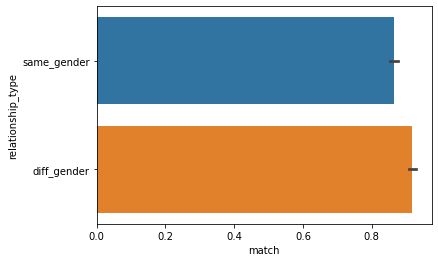

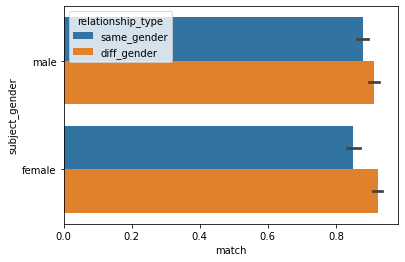

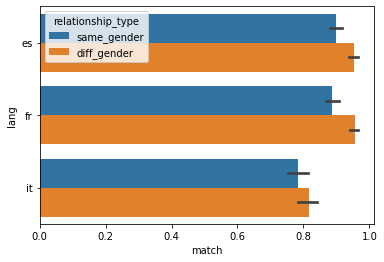

In [80]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
## flatten data for plot
flat_generated_data = pd.melt(generated_data, id_vars=['sent', 'relationship_type', 'subject_gender', 'lang'],
                              value_vars=['subject_gender_match'], value_name='match', var_name='match_type')
## overall
sns.barplot(data=flat_generated_data, y='relationship_type', x='match')
plt.show()
## per-type
type_vars = ['subject_gender', 'lang']
for type_var_i in type_vars:
    sns.barplot(data=flat_generated_data, y=type_var_i, x='match', hue='relationship_type')
    plt.show()